<font color='red'>**WARNING!**</font> <br>
 <font color='red'>**---------------------------------------------------------------------------------------------**</font> <br>
 <font color='red'>**DO NOT RUN THIS NOTEBOOK IN GOOGLE COLAB**</font> <br>
  <font color='red'>**IT MUST BE RUN LOCALLY USING [Jupyter](https://jupyter.org/)**</font> <BR>
    <font color='red'>**CHECK REQUIREMENTS   AND FOLLOW  INSTALLATION STEPS**</font>
-  ***REQUIREMENTS***:
	- [ ] **Kaggle Account** 
	- [ ] **OS**: Windows 8.1 64-bit or Windows 10 64-bit
	- [ ] **Memory**: 8 GB RAM
	- [ ] **Storage**: 140 GB available space
  
-  ***INSTALLATION*** :
	1.  Clone  repository: [Snake Classifier](https://github.com/deivid-01/Snakes-Classifier) </br>
	``git clone https://github.com/deivid-01/Snakes-Classifier`` </br>
	2.  Move to Snake-Classifier folder </br>
		``cd Snakes-Classifier``
	3.  Open  content in Jupyter
	4.  <font color='green'> **Run Notebook**</font> 
  
     <font color='red'>**---------------------------------------------------------------------------------------------**</font> <br>
	 This Notebook is part 2  of Deep Learning Project : [Snake Classifier](https://github.com/deivid-01/Snakes-Classifier) of the course [Fundamentos de Deep Learning](https://rramosp.github.io/2021.deeplearning/intro.html) <br>

---

# Data pre-processing  - Snakeclef2021

About:
- This notebook focus on pre-processing data that will be  use for test and training.
---
David Andrés Torres Betancour <br/>
Computer Engineering  Student <br/>
University of Antioquia <br/>
davida.torres@udea.edu.co <br/>
GitHub: deivid-01

## Importing Libraries

In [1]:
import h5py
import numpy as np
import cv2
import math
import time
import random
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
%matplotlib inline

## Main Configuration

In [2]:
KAGGLE_DATA_FOLDER ="kaggle_data" # Path  where dataset will be downloaded 
KAGGLE_DATASET_NAME = "snakeclef2021" # Dataset name in kaggle
PRE_PROCCESSED_DATA_FOLDER = "pre_proccesed_data" # 

## Tools

### Extra Tools

In [3]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def showMsg(bcolor,msg):
    '''
    Description:
      show colorfull message in the console

    Parameters:
        bcolor: bcolors type
          msg: Message to display
    Returns:
        Void   
    ''' 
    print(bcolor + msg+ bcolors.ENDC) 


def showRandomImage(x,y): 
  '''
    Description:
        Display random image selected from x and y

    Parameters:
        x: Numpy Array 
            y: Numpy Array
    Returns:
        Void   
  ''' 
  index = random.randint(0,x.shape[0])
  
  image = x[index]
  plt.imshow(image)
  print("Img shape:",image.shape)
  print('breed:', y[index])

def getRandomGroup(max_groups=1):
  '''
    Description:
        Get random group of .h5 Files

    Parameters:
        max_groups: Total groups (.h5 files)
    Returns:
        Void   
  ''' 
  group_num =str(random.randint(1,max_groups))
  destination_filepath =os.path.abspath('pre_proccesed_data/group_'+group_num+'.h5')
  with h5py.File(destination_filepath, "r") as f:
      
      
      showMsg(bcolors.WARNING , f"Reading data from group {group_num} !\n")

      x = f["input_data"][:]
      x = x.reshape(x.shape[0],224,224,3)

      y = f["input_labels"][:]

      print("Keys: ",list(f.keys()))
      print('x shape =', x.shape, '| y shape =', y.shape)
      
      
      
      return x,y,group_num

### Kaggle Tools

In [4]:
def credentialsUploaded():
  '''
      Description:
         waits and checks if  user has uploaded kaggle.json file

      Parameters:
          No parameters
      Returns:
          Void   
  '''  
    
  first_time = True;
  waiting_time = 0
  print()
  while checkIfFileExist('kaggle.json')==False and  waiting_time<180:
      if first_time:
        showMsg(bcolors.WARNING,"Upload kaggle.json file following the above instructions ^^^^^^^^\n ")  
        showMsg(bcolors.WARNING,"Waiting user upload kaggle.json file in root folder...\n ")  
        first_time = False
      time.sleep(2)
      waiting_time +=2
  if waiting_time>=120:
      raise Exception("kaggle.json file has not been uploaded") 
  showMsg(bcolors.OKGREEN," kaggle.json file uploaded!")  
  os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd() 

def relocateData(destination):
    '''
      Description:
         Moves data to the destination using shell commands in Windows

      Parameters:
          destination : Destination folder

      Returns:
          Void   
    ''' 

    !mkdir {destination}
    !move data {destination}
    !move data.csv {destination} 
    

def unzipData(dataset_name):
    '''
      Description:
         unzip file using shell commands in Windows

      Parameters:
          dataset_name: Dataset name in Kaggle

      Returns:
          Void   
    ''' 
    !tar -xf {dataset_name}.zip -v
    !del {dataset_name}.zip 

def fetchDatasetFromKaggle(dataset_name, force_fetch=False):
    '''
      Description:
      Download dataset from kaggleole

      Parameters:
       dataset_nameloDataset nameype
       force_fetchmsDelete local data and download the entire datasetlay
      Returns:
          Void     
    '''
    showMsg(bcolors.BOLD , "Fetching data from kaggle ( This may take some time)...")       
    if force_fetch==True:
        process_info= ! kaggle datasets download -d deividt/{dataset_name} --force #Download 
    
        if "100%" in list(process_info)[-1]:
            showMsg(bcolors.OKGREEN,"Data from kaggle successfully fetch\n")           
            showMsg(bcolors.BOLD , "Unzipping data... s\n")
            unzipData(KAGGLE_DATASET_NAME)
            showMsg(bcolors.BOLD , "Relocating data... s\n")
            relocateData(KAGGLE_DATA_FOLDER)
            showMsg(bcolors.OKGREEN , "Data is ready in your local folder!\n")
        elif "404 - Not Found" in list(process_info)[0]:
            showMsg(bcolors.FAIL , "404 - Dataset  Not Found in 'deividt' Account\n" )
        else:
            assert False,list(process_info)[-1]
    
    else:
        if checkIfFileExist("kaggle_data"):
            showMsg(bcolors.WARNING ,"Data already exists locally in 'kaggle_data' folder\nIf you want force fetch set force_fetch parameter to True")
            return
        process_info =  ! kaggle datasets download -d deividt/{dataset_name} 
        if "Skipping" in list(process_info)[0]:
            showMsg(bcolors.WARNING , "Data already exists locally\nIf you want force fetch set force_fetch parameter to True")
        elif "100%" in list(process_info)[-1]:
                showMsg(bcolors.OKGREEN , "Data from kaggle successfully fetch\n" )
                showMsg(bcolors.BOLD , "Unzipping data... s\n")
                unzipData(KAGGLE_DATASET_NAME)
                showMsg(bcolors.BOLD , "Relocating data... s\n")
                relocateData(KAGGLE_DATA_FOLDER)
                showMsg(bcolors.OKGREEN , "Data is ready in your local folder!\n")
        elif "404 - Not Found" in list(process_info)[0]: 
            showMsg(bcolors.FAIL , "404 - Dataset  Not Found in 'deividt' Account\n")
        else:
            assert False,list(process_info)[-1]
   
  

def kaggle_setConfig(dataset_title="testing"):
    '''
      Description:
      Create dataset-metada.json

      Parameters:
       dataset_title : Database name
      Returns:
          Void     
    '''
    fileName=os.path.abspath(f'{PRE_PROCCESSED_DATA_FOLDER}/dataset-metadata.json')
    !kaggle datasets init -p  {os.path.abspath(PRE_PROCCESSED_DATA_FOLDER)}
    addTitle2JSON(fileName,dataset_title)

def kaggle_createDataset(public=False):
    '''
        Description:
        Create dataset in kaggle 

        Parameters:
        public : Public->True/ Private->False
        Returns:
            Void     
    '''
    if public: 
        !kaggle datasets create -p  {os.path.abspath(PRE_PROCCESSED_DATA_FOLDER)} -u
    else: 
        !kaggle datasets create -p  {os.path.abspath(PRE_PROCCESSED_DATA_FOLDER)}
   
def kaggle_updateDataset(commit_message='Updating files'):
    !kaggle datasets version -p {os.path.abspath(PRE_PROCCESSED_DATA_FOLDER)} -m commit_message

def kaggle_saveData():

    '''
        Description:
        Save data in Kaggle

        Parameters:
        public : Public->True/ Private->False
        Returns:
            Void     
    '''  
    res = input("Do you want upload created data in  your kaggle Account? [y/n] ")

    if  res.lower()!="y" :
        return showMsg(bcolors.WARNING , f"Upload canceled \n")

    res = readOption( msg = "Create new dataset[1] or update old one[2]? [1/2]")

    dataset_title = input("Enter dataset name: ")
    assert len(res)>0 , "Invalid length "

    kaggle_setConfig(dataset_title)

    if res=="1": #Create new dataset
        res = readOption( msg = "Create dataset Private[1] or Public [2]? [1/2]" )
        public_dataset = True if int(res)==2 else False
        kaggle_createDataset(public_dataset)
    elif res=="2": #Update dataset
        commit_msg = input ("Enter commit message (Ex. 'version 1.4') : ")
        showMsg(bcolors.WARNING , f"Updating dataset in kaggle... \n")
        kaggle_updateDataset(commit_msg)


### Preprocessing Tools

In [5]:
def reOrderForGrouping(dataF,group_size):
    '''
      Description:
        Create new DataFrame  ordered in such a way that it can be sectioned by groups

      Parameters:
       dataF : dataFrame
       group_size: Total groups
      Returns:
          dataFrame     
    '''  
    dataF.sample(frac = 1)#Shuffle dataframe
    newDf = pd.DataFrame({'image_path' : [],'breed' : [],'breed_encode' : []})
    
    min_breedCount = dataF['breed'].value_counts()[-1]

    breeds = pd.unique(dataF['breed'])
    class_size = group_size //len(breeds)

    totalGroups = min_breedCount//class_size
  
    for i in range(totalGroups):

        for breed in   breeds :
            df_breed = dataF[dataF.breed==breed]
            df_breed = df_breed[class_size*i:class_size*(i+1)]
            newDf = newDf.append( df_breed )
    
    return newDf     

def selectTopBreeds(dataF,num=10):
  
    '''
      Description:
        Select breeds with most images

      Parameters:
        dataF: dataFrame
        num : Number of breeds to select
      Returns:
          list      
    '''  

    selected=dataF['binomial'].value_counts()[:num]
    return selected.index.tolist();




def normalize_and_write_data_into_h5_file(dataF,dest_filepath, n_px):
    '''
    Description:
      Change image size and image to h.5 file

    Parameters:
      dataF: dataFrame
      dest_filepath : file path
      n_px: Image size ( width:n_px , height: _npx)
    Returns:
        list      
    '''   

    data_shape = (len(dataF), n_px * n_px * 3)
    dataset_name = "input_data"
    

    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, data_shape, np.float32)      
        for i,image_id in enumerate(dataF['image_path']):
            path  = os.path.abspath(f'kaggle_data/{image_id}')
            try:
          
              img=cv2.imread(path)
              img = cv2.resize(img, (n_px, n_px), interpolation=cv2.INTER_CUBIC)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              #Normalize the image - convert the each pixel value between 0 and 1
              img = img / 255
                #Reshape the image - roll it up into a column vector
              img = img.ravel()            
              #img[None] makes it a proper array instead of rank 1 array
              f[dataset_name][i, ...] = img[None]
            except:
              continue
    return;


def fixImagePath(dataF):
    '''
    Description:
      Change original path to custom path

    Parameters:
      dataF: dataFrame
    Returns:
        list      
    '''  
    imgs_paths=dataF.image_path.tolist()
    for i,img_path in enumerate(imgs_paths):
        imgs_paths[i]='data/'+img_path.split('/')[-1]   
    return imgs_paths

def savePreproccessedCSV(dataF):
  '''
  Description:
    Save proccessed  dataFrame to .csv file

  Parameters:
    dataF: dataFrame
  Returns:
      None      
  '''   
  !mkdir pre_proccesed_data
  dataF.to_csv(os.path.abspath('pre_proccesed_data/pre_proccessed_data.csv'))
  showMsg(bcolors.OKGREEN , "pre_proccessed_data.csv saved!\n")


### File Tools 

In [6]:
def checkIfFileExist(file_name):
    '''
      Description:
        Check if file exist in local folder .

      Parameters:
          file_name : File name.

      Returns:
          True/False.   
    '''
    return os.path.exists(os.path.abspath(file_name))

def write_labels_into_h5_file(dest_filepath, labels):
    
    dataset_name = "input_labels"
    
    with h5py.File(dest_filepath, 'a') as f:
        f.create_dataset(dataset_name, (len(labels),), np.int8)
        f[dataset_name][...] = labels

def convert_images_to_data_in_h5_file(dataF, dest_h5_file_path, n_px, batch_size = 1024):
    


    #Create Labels based upon the substring contained in the filename
    labels = (dataF['breed_encode']).to_numpy()
    
    #Number of images
    m = len(dataF) 
    n_complete_batches = math.ceil(m / batch_size)
    
    pbar = tqdm(range(n_complete_batches))
    for i in pbar:
    
        dest_file_path = dest_h5_file_path + str(i + 1) + ".h5"   
        
        if checkIfFileExist(dest_file_path):
            print(bcolors.WARNING + f"Group {i+1} already exist in pre_proccessed_data  folder\n" + bcolors.ENDC)
            continue;
        pbar.set_description("Creating .h5 file for group %s" % (i+1))           
        start_pos = i * batch_size
        end_pos = min(start_pos + batch_size, m)
        df_filepaths_batch = dataF.iloc[start_pos: end_pos]
        labels_batch = labels[start_pos: end_pos]
        normalize_and_write_data_into_h5_file(df_filepaths_batch,dest_file_path, n_px)
        write_labels_into_h5_file(dest_file_path, labels_batch)

    print(bcolors.OKGREEN + "Images successfully saved in .h5 files !\n" + bcolors.ENDC)

def addTitle2JSON(fileName,dataset_title):
    data = readFile(fileName)
    data = addTitle2Data(data,dataset_title)
    writeFile(fileName,data)
    
def writeFile(fileName,data):
  with open(fileName,'w') as json_file:
      # Guardar la informacion
      json.dump(data,json_file)
      print("File "+fileName+" updated")

def readFile(fileName):
  with open(fileName, "r") as json_file: 
     return json.load(json_file)

def addTitle2Data(data,title):
  data['id'] = data['id'].split('/')[0]+'/'+title
  data['title'] = title
  return data
def readOption(msg):

  res = input(msg)
  assert res=='1' or res=='2',"Invalid option"
  return res

## Preprocessing data



### 0)   Fetch and read data :



1. Upload Kaggle credentials file ( kaggle.json  ) 

 - In order to use the Kaggle’s public API, you must first authenticate using an API token. For that follow the next steps: <br/> <br/>
     1. Go to https://www.kaggle.com/
     2. Click on your user profile picture
     3. Then on "Account" from the dropdown menu. This will take you yo your account settings
     4. Scroll down to the section of the page labelled API
     5. To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine named "kaggle.json"
     6.  <font color='red'>**YOU MUST UPLOAD kaggle.json FILE in the ROOT FOLDER**</font> 



In [7]:
credentialsUploaded()


 kaggle.json file uploaded!


2. Downloading original dataset [snakeclef2021](https://www.kaggle.com/deividt/snakeclef2021) from Kaggle. 
<br/>
<font color='red'>**Fetching data and unzipping files can take several minutes** ( at least 30 min)**  </font> 
 <br/>


In [8]:
fetchDatasetFromKaggle( dataset_name = "snakeclef2021")

Fetching data from kaggle ( This may take some time)...
Data already exists locally in 'kaggle_data' folder
If you want force fetch set force_fetch parameter to True


3. Read .csv :

In [9]:
df = pd.read_csv('kaggle_data/data.csv')
df.head(5)

,binomial,country,continent,genus,family,UUID,source,subset,class_id,image_path
0,Pantherophis spiloides,United States of America,North America,Pantherophis,Colubridae,fbc816e9552643a2bce4f655b2f3c4e1,inaturalist,train,523,/Datasets/SnakeCLEF-2021/inaturalist/fbc816e95...
1,Masticophis taeniatus,United States of America,North America,Masticophis,Colubridae,cbc7ad7141a642f2b92ef7fe05c9d608,inaturalist,train,430,/Datasets/SnakeCLEF-2021/inaturalist/cbc7ad714...
2,Crotalus pyrrhus,United States of America,North America,Crotalus,Viperidae,fc4db72953ae4c978ac50acb33adce0c,inaturalist,train,183,/Datasets/SnakeCLEF-2021/inaturalist/fc4db7295...
3,Haldea striatula,United States of America,North America,Haldea,Colubridae,2068c79c956d43dc8a45106e0c808aed,inaturalist,train,305,/Datasets/SnakeCLEF-2021/inaturalist/2068c79c9...
4,Natrix natrix,Russia,Europe,Natrix,Colubridae,3e376aaf4f8d42e991c0c8ddc5972f95,inaturalist,train,471,/Datasets/SnakeCLEF-2021/inaturalist/3e376aaf4...


### 1) Select top 10 breeds with most images

0. Check top 10 images

In [10]:
df['binomial'].value_counts()[:10]

Thamnophis sirtalis            22163
Storeria dekayi                17535
Pantherophis obsoletus         13012
Crotalus atrox                 12344
Nerodia sipedon                12211
Pituophis catenifer            11487
Pantherophis alleghaniensis     8846
Agkistrodon contortrix          8085
Diadophis punctatus             7689
Nerodia erythrogaster           7435
Name: binomial, dtype: int64

1. Select top 10 images:

In [11]:
selected_breed = selectTopBreeds(df,10)

2. Filter dataframe with selected breeds

In [12]:

df = df[df.binomial.isin(selected_breed)] 

print(pd.unique(df.binomial))

print("Total breeds:",len ( pd.unique(df.binomial)))

['Thamnophis sirtalis' 'Pituophis catenifer' 'Storeria dekayi'
 'Nerodia erythrogaster' 'Diadophis punctatus' 'Crotalus atrox'
 'Pantherophis alleghaniensis' 'Nerodia sipedon' 'Agkistrodon contortrix'
 'Pantherophis obsoletus']
Total breeds: 10


### 2) Drop and rename columns:

In [13]:
# 1. Dropping columns
df = df.drop(columns=['source','class_id','UUID','country','genus','family','continent','subset'])

# 2. Renaming columns
df.columns=['breed','image_path']

# 3. Show results
df.head(5)


,breed,image_path
14,Thamnophis sirtalis,/Datasets/SnakeCLEF-2021/inaturalist/2925c6778...
17,Pituophis catenifer,/Datasets/SnakeCLEF-2021/inaturalist/1b849238b...
21,Storeria dekayi,/Datasets/SnakeCLEF-2021/inaturalist/dab7fe49d...
22,Nerodia erythrogaster,/Datasets/SnakeCLEF-2021/inaturalist/7c4bd815b...
24,Diadophis punctatus,/Datasets/SnakeCLEF-2021/inaturalist/7060dc6cb...


4. Fix image_path

In [14]:
df.image_path = fixImagePath(df)
df

,breed,image_path
14,Thamnophis sirtalis,data/2925c677825448a7935fad227c1fa9b2.jpg
17,Pituophis catenifer,data/1b849238b16941b282c2d608a8c4c687.jpg
21,Storeria dekayi,data/dab7fe49d8204bce887305fd5fa887c0.jpg
22,Nerodia erythrogaster,data/7c4bd815bf0b4454b6db043fccd54fd1.jpg
24,Diadophis punctatus,data/7060dc6cb41e4fcc8415a9007ac3bca6.jpg
...,...,...
385993,Pituophis catenifer,data/2d39a392ecee4be1849d8d6c5e231c1f.jpg
386001,Storeria dekayi,data/f0a50a4676a34a2f99c3cb2451c6acd5.jpg
386002,Thamnophis sirtalis,data/4513bbe7752d49dabdff2dd6484c82fc.jpg
386003,Thamnophis sirtalis,data/fca4ce9644b84454bf2d2967bbfd6597.jpg


### 3) Encoding breeds

In [15]:
df['breed_encode'] = LE.fit_transform(df['breed'])
df.head(5)

,breed,image_path,breed_encode
14,Thamnophis sirtalis,data/2925c677825448a7935fad227c1fa9b2.jpg,9
17,Pituophis catenifer,data/1b849238b16941b282c2d608a8c4c687.jpg,7
21,Storeria dekayi,data/dab7fe49d8204bce887305fd5fa887c0.jpg,8
22,Nerodia erythrogaster,data/7c4bd815bf0b4454b6db043fccd54fd1.jpg,3
24,Diadophis punctatus,data/7060dc6cb41e4fcc8415a9007ac3bca6.jpg,2


### 4) Preparing dataframe for grouping:

In [16]:
df = reOrderForGrouping( df,group_size=2000)
df['breed'].value_counts()

Crotalus atrox                 7400
Agkistrodon contortrix         7400
Pituophis catenifer            7400
Diadophis punctatus            7400
Pantherophis alleghaniensis    7400
Nerodia sipedon                7400
Thamnophis sirtalis            7400
Storeria dekayi                7400
Nerodia erythrogaster          7400
Pantherophis obsoletus         7400
Name: breed, dtype: int64

### 5) Save preproccessed .csv

In [17]:
savePreproccessedCSV(df)

A subdirectory or file pre_proccesed_data already exists.


pre_proccessed_data.csv saved!



### 6)  Create groups and convert them to .h5 file

In [18]:

convert_images_to_data_in_h5_file(df, dest_h5_file_path=os.path.abspath('pre_proccesed_data')+'/group_', n_px = 224, batch_size= 2000)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 3085.21it/s]

Group 1 already exist in pre_proccessed_data  folder

Group 2 already exist in pre_proccessed_data  folder

Group 3 already exist in pre_proccessed_data  folder

Group 4 already exist in pre_proccessed_data  folder

Group 5 already exist in pre_proccessed_data  folder

Group 6 already exist in pre_proccessed_data  folder

Group 7 already exist in pre_proccessed_data  folder

Group 8 already exist in pre_proccessed_data  folder

Group 9 already exist in pre_proccessed_data  folder

Group 10 already exist in pre_proccessed_data  folder

Group 11 already exist in pre_proccessed_data  folder

Group 12 already exist in pre_proccessed_data  folder

Group 13 already exist in pre_proccessed_data  folder

Group 14 already exist in pre_proccessed_data  folder

Group 15 already exist in pre_proccessed_data  folder

Group 16 already exist in pre_proccessed_data  folder

Group 17 already exist in pre_proccessed_data  folder

Group 18 already exist in pre_proccessed_data  folder

Group 19 already ex

### 7) File verification





1. Select random group:






In [19]:
x,y,groupNum =getRandomGroup( max_groups=10 )

Reading data from group 3 !

Keys:  ['input_data', 'input_labels']
x shape = (2000, 224, 224, 3) | y shape = (2000,)


2. Select random image from selected group:

Img shape: (224, 224, 3)
breed: 5


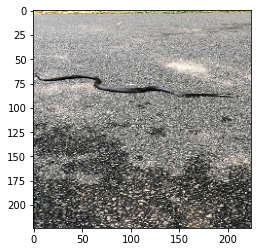

In [21]:
showRandomImage(x,y)

### 8) Saving created files in Kaggle 


In [ ]:
kaggle_saveData()

Do you want upload created data in  your kaggle Account? [y/n]  y
Create new dataset[1] or update old one[2]? [1/2] 2
Enter dataset name:  snake-breeds


Data package template written to: C:\Users\datcx\Documents\github\Snakes-Classifier\pre_proccesed_data\dataset-metadata.json
File C:\Users\datcx\Documents\github\Snakes-Classifier\pre_proccesed_data\dataset-metadata.json updated


Enter commit message (Ex. 'version 1.4') :  version 1.8


Updating dataset in kaggle... 

